ECE 9063 Data Analytics Project

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 3.0MB/s 


In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
import IPython
import kerastuner as kt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from joblib import dump, load

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Set Random Seeds

In [79]:
np.random.seed(42)
tf.random.set_seed(42)

Importing Data

In [80]:
# ============== Importing data ======================
featureFile = 'combined_data.csv'
featureData = pd.read_csv(featureFile)

labelFile = 'SyedHouse-GreenButton-2018-07-01-2020-02-29.csv'
labelData = pd.read_csv(labelFile)

# put feature and label in one object
data = pd.concat([featureData, labelData['Usage (kilowatt-hours)']], axis=1)
data

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Time,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,Rel Hum (%),Rel Hum Flag,Wind Dir (10s deg),Wind Dir Flag,Wind Spd (km/h),Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather,Usage (kilowatt-hours)
0,-81.15,43.03,LONDON A,6144473,2018-07-01 00:00,2018,7,1,00:00,25.0,NaN,20.9,NaN,78.0,NaN,21.0,NaN,10.0,NaN,24.1,NaN,98.35,NaN,33.0,NaN,NaN,NaN,NaN,3.53
1,-81.15,43.03,LONDON A,6144473,2018-07-01 01:00,2018,7,1,01:00,23.5,NaN,20.8,NaN,84.0,NaN,20.0,NaN,7.0,NaN,24.1,NaN,98.39,NaN,32.0,NaN,NaN,NaN,Clear,3.45
2,-81.15,43.03,LONDON A,6144473,2018-07-01 02:00,2018,7,1,02:00,22.9,NaN,20.6,NaN,86.0,NaN,19.0,NaN,5.0,NaN,24.1,NaN,98.39,NaN,31.0,NaN,NaN,NaN,NaN,3.36
3,-81.15,43.03,LONDON A,6144473,2018-07-01 03:00,2018,7,1,03:00,19.9,NaN,19.3,NaN,96.0,NaN,0.0,NaN,1.0,NaN,24.1,NaN,98.42,NaN,NaN,NaN,NaN,NaN,NaN,2.90
4,-81.15,43.03,LONDON A,6144473,2018-07-01 04:00,2018,7,1,04:00,20.1,NaN,19.6,NaN,97.0,NaN,26.0,NaN,5.0,NaN,24.1,NaN,98.38,NaN,27.0,NaN,NaN,NaN,Mainly Clear,2.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14611,-81.15,43.03,LONDON A,6144473,2020-02-29 19:00,2020,2,29,19:00,-6.7,NaN,-11.7,NaN,68.0,NaN,24.0,NaN,11.0,NaN,24.1,NaN,98.52,NaN,NaN,NaN,-12.0,NaN,Mainly Clear,0.84
14612,-81.15,43.03,LONDON A,6144473,2020-02-29 20:00,2020,2,29,20:00,-7.0,NaN,-11.5,NaN,71.0,NaN,23.0,NaN,11.0,NaN,24.1,NaN,98.53,NaN,NaN,NaN,-12.0,NaN,NaN,0.88
14613,-81.15,43.03,LONDON A,6144473,2020-02-29 21:00,2020,2,29,21:00,-7.1,NaN,-11.2,NaN,73.0,NaN,20.0,NaN,9.0,NaN,24.1,NaN,98.52,NaN,NaN,NaN,-11.0,NaN,NaN,0.98
14614,-81.15,43.03,LONDON A,6144473,2020-02-29 22:00,2020,2,29,22:00,-9.1,NaN,-12.0,NaN,80.0,NaN,20.0,NaN,8.0,NaN,24.1,NaN,98.52,NaN,NaN,NaN,-13.0,NaN,Clear,0.93


# Data Preprocessing

Data Cleaning

In [81]:
# ================= Data Cleaning =======================

# drop the columns with mostly missing values
data = data.drop(columns=["Temp Flag", "Dew Point Temp Flag", "Rel Hum Flag", "Wind Dir Flag", "Wind Spd Flag",
                   "Visibility Flag", "Stn Press Flag", "Hmdx", "Hmdx Flag", "Wind Chill", "Wind Chill Flag"])

# drop columns with constant data
data = data.drop(columns=["Longitude (x)", "Latitude (y)", "Station Name", "Climate ID", 'Date/Time'])

print(data.isnull().sum())

Year                         0
Month                        0
Day                          0
Time                         0
Temp (°C)                    9
Dew Point Temp (°C)          9
Rel Hum (%)                  9
Wind Dir (10s deg)          19
Wind Spd (km/h)              9
Visibility (km)              8
Stn Press (kPa)              9
Weather                   7211
Usage (kilowatt-hours)       0
dtype: int64


In [82]:
# Deal with missing values
columns_to_clean = ["Temp (°C)", "Dew Point Temp (°C)", "Rel Hum (%)", "Wind Dir (10s deg)", "Wind Spd (km/h)",
                    "Visibility (km)", "Stn Press (kPa)"]

# replace with previous hour data
for col in columns_to_clean:
    data[col].fillna(method='ffill', inplace=True)
    
print(data.isnull().sum())


Year                         0
Month                        0
Day                          0
Time                         0
Temp (°C)                    0
Dew Point Temp (°C)          0
Rel Hum (%)                  0
Wind Dir (10s deg)           0
Wind Spd (km/h)              0
Visibility (km)              0
Stn Press (kPa)              0
Weather                   7211
Usage (kilowatt-hours)       0
dtype: int64


In [83]:
# clean the "weather" attribute: replace missing values with previous observations
data["Weather"].fillna(method='ffill', inplace=True)

print(data.isnull().sum())

Year                      0
Month                     0
Day                       0
Time                      0
Temp (°C)                 0
Dew Point Temp (°C)       0
Rel Hum (%)               0
Wind Dir (10s deg)        0
Wind Spd (km/h)           0
Visibility (km)           0
Stn Press (kPa)           0
Weather                   1
Usage (kilowatt-hours)    0
dtype: int64


Feature Engineering

Hour of Day

In [ ]:
data['Time'] = data['Time'].apply(lambda s: float(s.split(':')[0]))

data

,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather,Usage (kilowatt-hours)
0,2018,7,1,0.0,25.0,20.9,78.0,21.0,10.0,24.1,98.35,Clear,3.53
1,2018,7,1,1.0,23.5,20.8,84.0,20.0,7.0,24.1,98.39,Clear,3.45
2,2018,7,1,2.0,22.9,20.6,86.0,19.0,5.0,24.1,98.39,Clear,3.36
3,2018,7,1,3.0,19.9,19.3,96.0,0.0,1.0,24.1,98.42,Clear,2.90
4,2018,7,1,4.0,20.1,19.6,97.0,26.0,5.0,24.1,98.38,Mainly Clear,2.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14611,2020,2,29,19.0,-6.7,-11.7,68.0,24.0,11.0,24.1,98.52,Mainly Clear,0.84
14612,2020,2,29,20.0,-7.0,-11.5,71.0,23.0,11.0,24.1,98.53,Mainly Clear,0.88
14613,2020,2,29,21.0,-7.1,-11.2,73.0,20.0,9.0,24.1,98.52,Mainly Clear,0.98
14614,2020,2,29,22.0,-9.1,-12.0,80.0,20.0,8.0,24.1,98.52,Clear,0.93


Day of Week ( 1 ~ 7 for Mon ~ Sun)

In [ ]:
# 2018.7.1 Sunday, 2020.2.29 Saturday

day_week = []
counter = 0

for day in range(len(data)):
  if 0<= counter <= 23:
    day_week.append(7)
  elif 24 <= counter <=47:
    day_week.append(1)
  elif 48<= counter <= 71:
    day_week.append(2)
  elif 72 <= counter <= 95:
    day_week.append(3)
  elif 96 <= counter <=119:
    day_week.append(4)
  elif 120 <=counter <= 143:
    day_week.append(5)
  elif 144 <= counter <=167:
    day_week.append(6)
  
  counter += 1

  if counter > 167:
    counter = 0

day_week = pd.DataFrame(data=day_week, columns=['day_week'])
day_week

data = pd.concat([data, day_week], axis=1)

,day_week
0,7
1,7
2,7
3,7
4,7
...,...
14611,6
14612,6
14613,6
14614,6


Usage at previous timesteps as features

In [ ]:
steps = 7

for i in range(1,steps):
  data['Previous_Usage' + str(i)] = data['Usage (kilowatt-hours)'].shift(i)
  
for i in range(steps-1):
  data.drop(index=i, inplace=True)

data = pd.DataFrame.reset_index(data, drop=True)
data

,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather,Usage (kilowatt-hours),day_week,Previous_Usage1,Previous_Usage2,Previous_Usage3,Previous_Usage4,Previous_Usage5,Previous_Usage6
0,2018,7,1,6.0,21.8,20.8,94.0,16.0,4.0,16.1,98.39,Mainly Clear,2.08,7,2.83,2.77,2.90,3.36,3.45,3.53
1,2018,7,1,7.0,24.8,21.8,83.0,19.0,9.0,24.1,98.43,Mainly Clear,1.18,7,2.08,2.83,2.77,2.90,3.36,3.45
2,2018,7,1,8.0,26.6,22.7,79.0,18.0,9.0,24.1,98.44,Mainly Clear,2.46,7,1.18,2.08,2.83,2.77,2.90,3.36
3,2018,7,1,9.0,28.2,23.4,75.0,18.0,14.0,24.1,98.46,Mainly Clear,2.95,7,2.46,1.18,2.08,2.83,2.77,2.90
4,2018,7,1,10.0,29.4,23.7,71.0,17.0,14.0,24.1,98.42,Mainly Clear,2.96,7,2.95,2.46,1.18,2.08,2.83,2.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14605,2020,2,29,19.0,-6.7,-11.7,68.0,24.0,11.0,24.1,98.52,Mainly Clear,0.84,6,0.87,0.71,0.83,0.67,0.86,0.82
14606,2020,2,29,20.0,-7.0,-11.5,71.0,23.0,11.0,24.1,98.53,Mainly Clear,0.88,6,0.84,0.87,0.71,0.83,0.67,0.86
14607,2020,2,29,21.0,-7.1,-11.2,73.0,20.0,9.0,24.1,98.52,Mainly Clear,0.98,6,0.88,0.84,0.87,0.71,0.83,0.67
14608,2020,2,29,22.0,-9.1,-12.0,80.0,20.0,8.0,24.1,98.52,Clear,0.93,6,0.98,0.88,0.84,0.87,0.71,0.83


Season Feature





In [ ]:
season = []
for month in data['Month']:
  if 4 <= month <= 5:
    season.append(1)
  elif 6 <= month <= 9:
    season.append(2)
  elif 10 <= month <= 11:
    season.append(3)
  elif 12 == month or month <= 3:
    season.append(4)

season = pd.DataFrame(data=season, columns=['Season'])
season

data = pd.concat([data, season], axis=1)

,Season
0,2
1,2
2,2
3,2
4,2
...,...
14605,4
14606,4
14607,4
14608,4


# Exploratory Data Analysis

<Figure size 720x360 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f54e0b2e7f0>,
 [Text(0, 0, '2018.07'),
  Text(0, 0, '2018-09'),
  Text(0, 0, '2018-11'),
  Text(0, 0, '2019-01'),
  Text(0, 0, '2019-03'),
  Text(0, 0, '2019-05'),
  Text(0, 0, '2019-07'),
  Text(0, 0, '2019-09'),
  Text(0, 0, '2019-11'),
  Text(0, 0, '2020-01')])

Text(0.5, 1.0, 'Energy Consumption Pattern')

Text(0.5, 0, 'Date (YYYY-MM)')

Text(0, 0.5, 'Consumption - kWh')

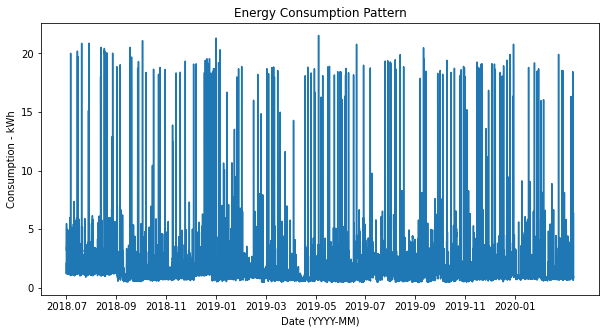

Text(0.5, 1.0, 'Energy Consumption Pattern - Week 1')

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Consumption - kWh')

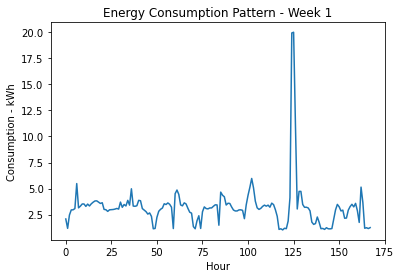

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data['Usage (kilowatt-hours)'])
positions = (0, 1440, 2880, 4320, 5760, 7200, 8600, 10040, 11480, 12920)
labels = ('2018.07', '2018-09', '2018-11', '2019-01', '2019-03', '2019-05', '2019-07', '2019-09', '2019-11', '2020-01')
plt.xticks(positions, labels)
plt.title('Energy Consumption Pattern')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Consumption - kWh')
plt.show()

# close up on the first week
plt.plot(data['Usage (kilowatt-hours)'].head(168))
plt.title('Energy Consumption Pattern - Week 1')
plt.xlabel('Hour')
plt.ylabel('Consumption - kWh')
plt.show()

Text(0.5, 1.0, 'Energy Consumption Pattern - Week 2')

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Consumption - kWh')

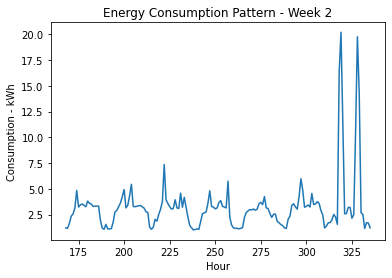

In [ ]:
# Second week
plt.plot(data['Usage (kilowatt-hours)'][168:336])
plt.title('Energy Consumption Pattern - Week 2')
plt.xlabel('Hour')
plt.ylabel('Consumption - kWh')
plt.show()

Temp vs Usage

Text(0.5, 0, 'Temperature - °C')

Text(0, 0.5, 'Consumption - kWh')

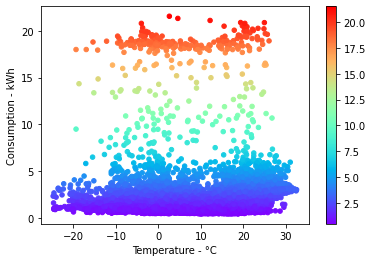

In [ ]:
data.plot(kind='scatter', x='Temp (°C)', y='Usage (kilowatt-hours)', 
          c=data['Usage (kilowatt-hours)'], cmap=plt.get_cmap('rainbow'), colorbar=True, sharex=False)
plt.xlabel('Temperature - °C')
plt.ylabel('Consumption - kWh')

Hum vs Usage

Text(0.5, 0, 'Humidity - %')

Text(0, 0.5, 'Consumption - kWh')

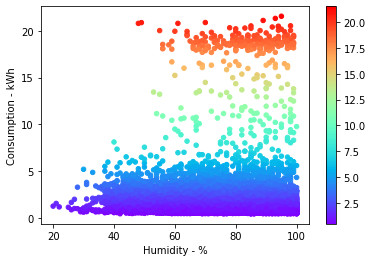

In [ ]:
data.plot(kind='scatter', x='Rel Hum (%)', y='Usage (kilowatt-hours)',
          c=data['Usage (kilowatt-hours)'], cmap='rainbow', colorbar=True, sharex=False)
plt.xlabel('Humidity - %')
plt.ylabel('Consumption - kWh')

Time vs Usage

Text(0.5, 0, 'Hour of the day')

Text(0, 0.5, 'Consumption - kWh')

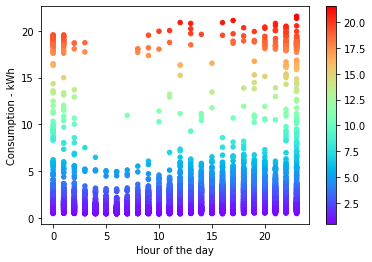

In [ ]:
data.plot(kind='scatter', x='Time', y='Usage (kilowatt-hours)',
          c=data['Usage (kilowatt-hours)'], cmap='rainbow', colorbar=True, sharex=False)
plt.xlabel('Hour of the day')
plt.ylabel('Consumption - kWh')

Day in week vs Usage

([<matplotlib.axis.XTick at 0x7f6e15f05cc0>,
 [Text(0, 0, 'Mon'),
  Text(0, 0, 'Tue'),
  Text(0, 0, 'Wed'),
  Text(0, 0, 'Thu'),
  Text(0, 0, 'Fri'),
  Text(0, 0, 'Sat'),
  Text(0, 0, 'Sun')])

Text(0, 0.5, 'Consumption - kWh')

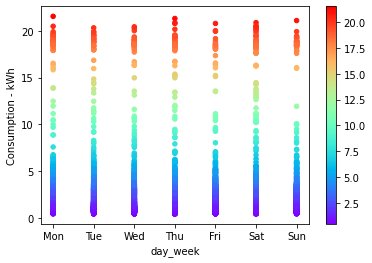

In [ ]:
data.plot(kind='scatter', x='day_week', y='Usage (kilowatt-hours)',
          c=data['Usage (kilowatt-hours)'], cmap='rainbow', colorbar=True, sharex=False)
positions = (1, 2, 3, 4, 5, 6, 7)
labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun')
plt.xticks(positions, labels)
plt.ylabel('Consumption - kWh')

Season vs Usage

([<matplotlib.axis.XTick at 0x7f6e15e3a908>,
 [Text(0, 0, 'Spring'),
  Text(0, 0, 'Summer'),
  Text(0, 0, 'Autumn'),
  Text(0, 0, 'Winter')])

Text(0, 0.5, 'Consumption - kWh')

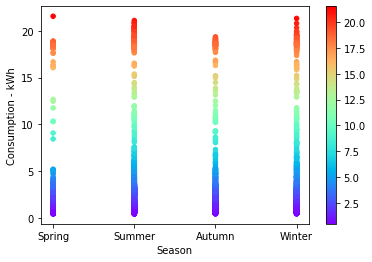

In [ ]:
data.plot(kind='scatter', x='Season', y='Usage (kilowatt-hours)',
          c=data['Usage (kilowatt-hours)'], cmap='rainbow', colorbar=True, sharex=False)
positions = (1, 2, 3, 4)
labels = ('Spring', 'Summer', 'Autumn', 'Winter')
plt.xticks(positions, labels)
plt.ylabel('Consumption - kWh')

# Data Preparation

Unit Circle Mapping for Cyclical Features

In [ ]:
def encode_cyclical(data, col, max_val):
  data[col + '_sin'] = np.sin(2*np.pi*data[col]/max_val)
  data[col + '_cos'] = np.cos(2*np.pi*data[col]/max_val)

  data.drop(columns=[col], inplace=True)
  return data


data = encode_cyclical(data, 'Month', 12)
data = encode_cyclical(data, 'Time', 24)
data = encode_cyclical(data, 'Season', 4)
data = encode_cyclical(data, 'day_week', 7)

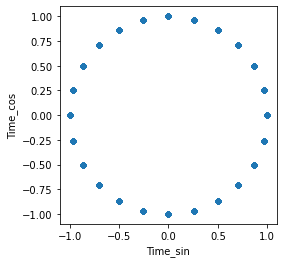

In [ ]:
data.plot.scatter('Time_sin', 'Time_cos').set_aspect('equal')

In [ ]:
data_onehot = data.copy()

# Discard features
data_onehot = data_onehot.drop(columns=['Weather', 'Year', 'Day'], axis=1)

data_onehot

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Usage (kilowatt-hours),Previous_Usage1,Previous_Usage2,Previous_Usage3,Previous_Usage4,Previous_Usage5,Previous_Usage6,Month_sin,Month_cos,Time_sin,Time_cos,Season_sin,Season_cos,day_week_sin,day_week_cos
0,21.8,20.8,94.0,16.0,4.0,16.1,98.39,2.08,2.83,2.77,2.90,3.36,3.45,3.53,-0.500000,-0.866025,1.000000,6.123234e-17,1.224647e-16,-1.0,-2.449294e-16,1.00000
1,24.8,21.8,83.0,19.0,9.0,24.1,98.43,1.18,2.08,2.83,2.77,2.90,3.36,3.45,-0.500000,-0.866025,0.965926,-2.588190e-01,1.224647e-16,-1.0,-2.449294e-16,1.00000
2,26.6,22.7,79.0,18.0,9.0,24.1,98.44,2.46,1.18,2.08,2.83,2.77,2.90,3.36,-0.500000,-0.866025,0.866025,-5.000000e-01,1.224647e-16,-1.0,-2.449294e-16,1.00000
3,28.2,23.4,75.0,18.0,14.0,24.1,98.46,2.95,2.46,1.18,2.08,2.83,2.77,2.90,-0.500000,-0.866025,0.707107,-7.071068e-01,1.224647e-16,-1.0,-2.449294e-16,1.00000
4,29.4,23.7,71.0,17.0,14.0,24.1,98.42,2.96,2.95,2.46,1.18,2.08,2.83,2.77,-0.500000,-0.866025,0.500000,-8.660254e-01,1.224647e-16,-1.0,-2.449294e-16,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14605,-6.7,-11.7,68.0,24.0,11.0,24.1,98.52,0.84,0.87,0.71,0.83,0.67,0.86,0.82,0.866025,0.500000,-0.965926,2.588190e-01,-2.449294e-16,1.0,-7.818315e-01,0.62349
14606,-7.0,-11.5,71.0,23.0,11.0,24.1,98.53,0.88,0.84,0.87,0.71,0.83,0.67,0.86,0.866025,0.500000,-0.866025,5.000000e-01,-2.449294e-16,1.0,-7.818315e-01,0.62349
14607,-7.1,-11.2,73.0,20.0,9.0,24.1,98.52,0.98,0.88,0.84,0.87,0.71,0.83,0.67,0.866025,0.500000,-0.707107,7.071068e-01,-2.449294e-16,1.0,-7.818315e-01,0.62349
14608,-9.1,-12.0,80.0,20.0,8.0,24.1,98.52,0.93,0.98,0.88,0.84,0.87,0.71,0.83,0.866025,0.500000,-0.500000,8.660254e-01,-2.449294e-16,1.0,-7.818315e-01,0.62349


Data Splitting & Standardization

In [ ]:
X = data_onehot.drop(columns=['Usage (kilowatt-hours)'], axis=1)
Y = data_onehot[['Usage (kilowatt-hours)']]

# split training, validation, test set as 60% : 20% : 20%
X_train_full, X_test, Y_train_full, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_full, Y_train_full, test_size=0.25, random_state=42, shuffle=False)


print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

# standardization
# scalerX = StandardScaler()
# X_train_scaled = scalerX.fit_transform(X_train)
# X_valid_scaled = scalerX.transform(X_valid)
# X_test_scaled = scalerX.transform(X_test)

# ========= Avoid scaling on one-hot and unit-mapped features ============
X_train_scaled = X_train.copy()
X_valid_scaled = X_valid.copy()
X_test_scaled = X_test.copy()

scale_cols = ['Temp (°C)', 'Dew Point Temp (°C)', 'Rel Hum (%)', 
              'Wind Dir (10s deg)', 'Wind Spd (km/h)',
              'Visibility (km)', 'Stn Press (kPa)']

previous_usage_cols = []
for i in range(1,steps):
  previous_usage_cols.append('Previous_Usage' + str(i))


scale_cols = scale_cols + previous_usage_cols

for col in scale_cols:
  scalerX = StandardScaler().fit(X_train[[col]])
  X_train_scaled[col] = scalerX.transform(X_train_scaled[[col]])
  X_valid_scaled[col] = scalerX.transform(X_valid_scaled[[col]])
  X_test_scaled[col] = scalerX.transform(X_test_scaled[[col]])


scalerY = StandardScaler()
Y_train_scaled = scalerY.fit_transform(Y_train)
Y_valid_scaled = scalerY.transform(Y_valid)
Y_test_scaled = scalerY.transform(Y_test)

X_train_scaled


scalerX.fit(X_train)
# save the scaler instance
dump(scalerX, 'scalerX.joblib')
dump(scalerY, 'scalerY.joblib')


(8766, 21)
(2922, 21)
(2922, 21)


,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Previous_Usage1,Previous_Usage2,Previous_Usage3,Previous_Usage4,Previous_Usage5,Previous_Usage6,Month_sin,Month_cos,Time_sin,Time_cos,Season_sin,Season_cos,day_week_sin,day_week_cos
0,1.247307,1.530523,1.002203,-0.444096,-1.244063,-0.508403,0.019740,0.333148,0.309900,0.360223,0.538298,0.573039,0.603910,-0.5,-0.866025,1.000000,6.123234e-17,1.224647e-16,-1.0,-2.449294e-16,1.00000
1,1.514377,1.621321,0.298641,-0.148107,-0.658006,0.600954,0.074790,0.042615,0.333143,0.309864,0.360106,0.538175,0.572921,-0.5,-0.866025,0.965926,-2.588190e-01,1.224647e-16,-1.0,-2.449294e-16,1.00000
2,1.674619,1.703040,0.042801,-0.246770,-0.658006,0.600954,0.088553,-0.306026,0.042610,0.333107,0.309747,0.359984,0.538058,-0.5,-0.866025,0.866025,-5.000000e-01,1.224647e-16,-1.0,-2.449294e-16,1.00000
3,1.817056,1.766598,-0.213040,-0.246770,-0.071950,0.600954,0.116078,0.189818,-0.306030,0.042575,0.332990,0.309626,0.359870,-0.5,-0.866025,0.707107,-7.071068e-01,1.224647e-16,-1.0,-2.449294e-16,1.00000
4,1.923885,1.793838,-0.468881,-0.345433,-0.071950,0.600954,0.061028,0.379634,0.189813,-0.306062,0.042460,0.332868,0.309512,-0.5,-0.866025,0.500000,-8.660254e-01,1.224647e-16,-1.0,-2.449294e-16,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8761,0.837799,0.894935,0.106761,-1.036075,-0.658006,0.600954,0.047265,-0.360259,-0.530709,-0.519118,-0.534727,-0.387642,1.564578,-0.5,-0.866025,0.965926,-2.588190e-01,1.224647e-16,-1.0,7.818315e-01,0.62349
8762,1.087065,1.058372,-0.213040,-0.444096,-0.658006,0.600954,0.019740,-0.472598,-0.360263,-0.530739,-0.519232,-0.534843,-0.387747,-0.5,-0.866025,0.866025,-5.000000e-01,1.224647e-16,-1.0,7.818315e-01,0.62349
8763,1.300721,0.913095,-1.300363,0.147882,-0.658006,0.600954,0.005977,-0.476472,-0.472603,-0.360294,-0.530853,-0.519348,-0.534946,-0.5,-0.866025,0.707107,-7.071068e-01,1.224647e-16,-1.0,7.818315e-01,0.62349
8764,1.425353,0.931254,-1.556204,0.937187,-0.189161,0.600954,0.088553,0.061984,-0.476476,-0.472633,-0.360409,-0.530969,-0.519451,-0.5,-0.866025,0.500000,-8.660254e-01,1.224647e-16,-1.0,7.818315e-01,0.62349


StandardScaler(copy=True, with_mean=True, with_std=True)

['scalerX.joblib']

['scalerY.joblib']

# Modeling

In [ ]:
# ========================= Hyper-parameter Tuning ==============================

# tune batch size
class MyTuner(kt.tuners.RandomSearch):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Choice('batch', values=[8, 16, 32])
    super(MyTuner, self).run_trial(trial, *args, **kwargs)


input_shape = X_train.shape[1:]


def build_model(hp):
    model = keras.models.Sequential()

    hp_neurons = hp.Choice('neurons', values=[30, 40, 50])
    hp_layers = hp.Choice('layers', values=[3, 4, 5, 6])
    hp_regularize = hp.Choice('regularize', values=[0.01, 0.02, 0.03])
    
    # input layer
    model.add(layers.Dense(X_train_scaled.shape[1], activation='elu', kernel_initializer='he_normal', input_shape=input_shape))

    # hidden layers
    for layer in range(hp_layers):
        model.add(layers.Dense(units=hp_neurons, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(hp_regularize)))

    # output layer
    model.add(layers.Dense(1, kernel_initializer='he_normal'))

    optimizer = keras.optimizers.Nadam()
    model.compile(loss='mse', optimizer=optimizer)
    return model


early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True, mode='min')

tuner = MyTuner(build_model, objective='val_loss', max_trials=30, seed=42)

tuner.search(X_train_scaled, Y_train_scaled, epochs=100, validation_data=(X_valid_scaled, Y_valid_scaled), callbacks=[early_stopping_cb])


Trial 30 Complete [00h 00m 28s]
val_loss: 0.5659098029136658

Best val_loss So Far: 0.524373471736908
Total elapsed time: 00h 30m 09s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# display tuning results
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
neurons: 30
layers: 3
regularize: 0.01
batch: 16
Score: 0.524373471736908
Trial summary
Hyperparameters:
neurons: 30
layers: 3
regularize: 0.01
batch: 8
Score: 0.5307955741882324
Trial summary
Hyperparameters:
neurons: 50
layers: 3
regularize: 0.02
batch: 8
Score: 0.5347056984901428
Trial summary
Hyperparameters:
neurons: 40
layers: 3
regularize: 0.02
batch: 16
Score: 0.5358768701553345
Trial summary
Hyperparameters:
neurons: 50
layers: 3
regularize: 0.02
batch: 8
Score: 0.5384050607681274
Trial summary
Hyperparameters:
neurons: 50
layers: 3
regularize: 0.03
batch: 8
Score: 0.5389614701271057
Trial summary
Hyperparameters:
neurons: 40
layers: 3
regularize: 0.01
batch: 32
Score: 0.540965735912323
Trial summary
Hyperparameters:
neurons: 30
layers: 4
regularize: 0.01
batch: 8
Score: 0.5426626801490784
Trial summary
Hyperparameters:
neurons: 40
lay

In [ ]:
#Retain the optimal hyper-parameters found and re-train the model

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

model = tuner.hypermodel.build(best_hps)

history = model.fit(X_train_scaled, Y_train_scaled, epochs=100, validation_data=(X_valid_scaled, Y_valid_scaled), callbacks=[early_stopping_cb])

model.summary()

Epoch 1/100
274/274 [==============================] - 0s 2ms/step - loss: 2.4693 - val_loss: 2.0131
Epoch 2/100
274/274 [==============================] - 0s 1ms/step - loss: 1.8596 - val_loss: 1.6833
Epoch 3/100
274/274 [==============================] - 0s 1ms/step - loss: 1.5819 - val_loss: 1.4528
Epoch 4/100
274/274 [==============================] - 0s 1ms/step - loss: 1.3610 - val_loss: 1.2643
Epoch 5/100
274/274 [==============================] - 0s 1ms/step - loss: 1.1950 - val_loss: 1.1088
Epoch 6/100
274/274 [==============================] - 0s 1ms/step - loss: 1.0606 - val_loss: 1.0194
Epoch 7/100
274/274 [==============================] - 0s 1ms/step - loss: 0.9541 - val_loss: 0.9295
Epoch 8/100
274/274 [==============================] - 0s 1ms/step - loss: 0.8739 - val_loss: 0.8507
Epoch 9/100
274/274 [==============================] - 0s 1ms/step - loss: 0.8016 - val_loss: 0.8021
Epoch 10/100
274/274 [==============================] - 0s 1ms/step - loss: 0.7486 - val_lo

In [ ]:
# model = keras.models.Sequential([
#     layers.Dense(X_train_scaled.shape[1], input_shape=X_train_scaled.shape[1:], activation='elu', kernel_initializer='he_normal'),
#     layers.Dense(30, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02)),
#     layers.Dense(30, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02)),
#     layers.Dense(30, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02)),
#     layers.Dense(30, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02)),
#     layers.Dense(1, kernel_initializer='he_normal')
# ])

# model.summary()

# early_stopping_cb = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)

# model.compile(loss='mse', optimizer='Nadam', metrics=[keras.metrics.RootMeanSquaredError()])
# history = model.fit(X_train_scaled, Y_train_scaled, epochs=100, validation_data=(X_valid_scaled, Y_valid_scaled),
#                     callbacks=[early_stopping_cb])


Save the model

In [ ]:
model.save('FFNN.h5')

Plot Loss vs Epochs

Text(0.5, 1.0, 'Model Loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

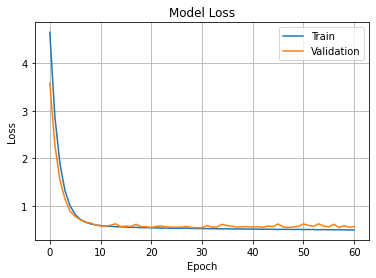

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

# Accuracy & Evaluation

Train Set Performance

,predicted,actual
0,2.44,2.08
1,2.18,1.18
2,1.85,2.46
3,3.05,2.95
4,3.29,2.96
...,...,...
8761,0.98,0.75
8762,1.26,0.74
8763,1.67,2.13
8764,2.84,2.66


<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Consumption - kWh')

Text(0.5, 1.0, 'Predicted vs Actual in Train set')

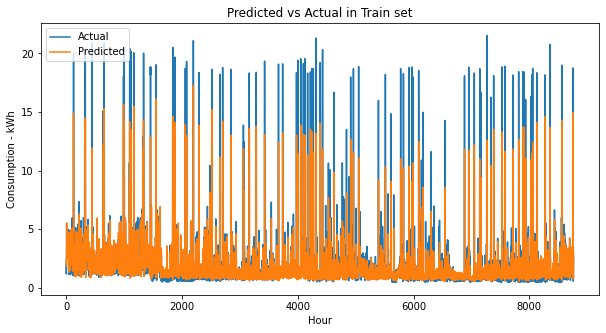

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Consumption - kWh')

Text(0.5, 1.0, 'Predicted vs Actual in Train set')

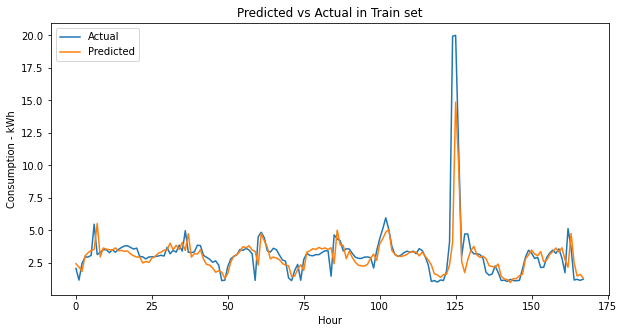

In [ ]:
# train set performance
Y_train_pred_scaled = model.predict(X_train_scaled)
Y_train_pred = scalerY.inverse_transform(Y_train_pred_scaled)

results = X_train.copy()
results["predicted"] = Y_train_pred
results["actual"] = Y_train
results = results[['predicted', 'actual']]
results['predicted'] = results['predicted'].round(2)
results

# reset the index of DataFrame and use the default indexing (0 1 2 3...N-1)
results = pd.DataFrame.reset_index(results, drop=True)

# visualize predicted vs actual in train set
plt.figure(figsize=(10,5))
plt.plot(results['actual'], label='Actual')
plt.plot(results['predicted'], label='Predicted')
plt.xlabel('Hour')
plt.ylabel('Consumption - kWh')
plt.title('Predicted vs Actual in Train set')
plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=(10,5))
plt.plot(results['actual'].head(168), label='Actual')
plt.plot(results['predicted'].head(168), label='Predicted')
plt.xlabel('Hour')
plt.ylabel('Consumption - kWh')
plt.title('Predicted vs Actual in Train set')
plt.legend(loc='upper left')
plt.show()

Test Set Performance

,predicted,actual
11688,0.82,0.77
11689,0.86,0.54
11690,0.81,0.71
11691,0.89,0.70
11692,0.91,0.56
...,...,...
14605,1.32,0.84
14606,1.37,0.88
14607,1.37,0.98
14608,1.40,0.93


<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Consumption - kWh')

Text(0.5, 1.0, 'Predicted vs Actual in Test set')

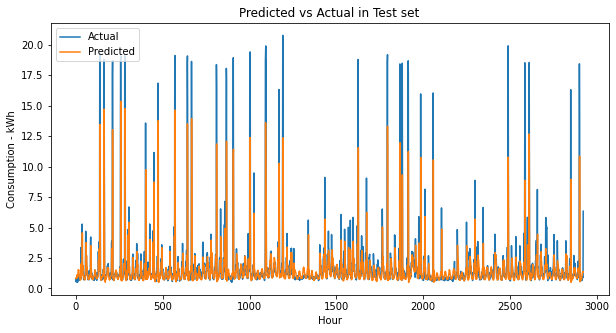

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Consumption - kWh')

Text(0.5, 1.0, 'Predicted vs Actual in Test set')

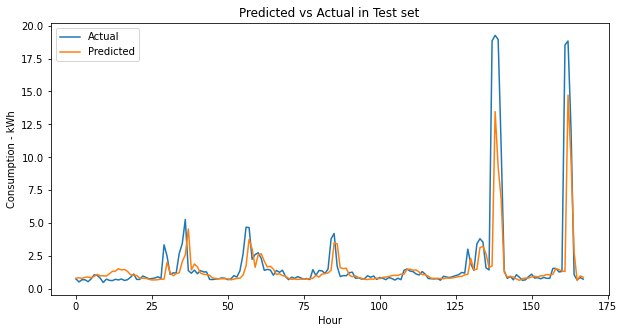

In [ ]:
# test set performance
Y_test_pred_scaled = model.predict(X_test_scaled)
Y_test_pred = scalerY.inverse_transform(Y_test_pred_scaled)

# copy the DataFrame indexes
test_results = X_test.copy()
test_results["predicted"] = Y_test_pred
test_results["actual"] = Y_test
test_results = test_results[['predicted', 'actual']]
test_results['predicted'] = test_results['predicted'].round(2)
test_results

# reset the index of DataFrame and use the default indexing (0 1 2 3...N-1)
test_results = pd.DataFrame.reset_index(test_results, drop=True)

# visualize predicted vs actual in test set
plt.figure(figsize=(10,5))
plt.plot(test_results['actual'], label='Actual')
plt.plot(test_results['predicted'], label='Predicted')
plt.xlabel('Hour')
plt.ylabel('Consumption - kWh')
plt.title('Predicted vs Actual in Test set')
plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=(10,5))
plt.plot(test_results['actual'].head(168), label='Actual')
plt.plot(test_results['predicted'].head(168), label='Predicted')
plt.xlabel('Hour')
plt.ylabel('Consumption - kWh')
plt.title('Predicted vs Actual in Test set')
plt.legend(loc='upper left')
plt.show()

In [ ]:
mape = tf.keras.losses.MeanAbsolutePercentageError()

In [ ]:
# Error Metric summary
model_performance = pd.DataFrame(columns=['Train MAE', 'Train MAPE', 'Train RMSE', 'Test MAE', 'Test MAPE', 'Test RMSE'])

Train_MAE = mean_absolute_error(Y_train, Y_train_pred)
Train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
Train_MAPE = mape(Y_train, Y_train_pred).numpy()

Test_MAE = mean_absolute_error(Y_test, Y_test_pred)
Test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
Test_MAPE = mape(Y_test, Y_test_pred).numpy()

model_performance = model_performance.append({
                        'Train MAE': Train_MAE,
                        'Train MAPE': Train_MAPE,
                        'Train RMSE': Train_RMSE,
                        'Test MAE': Test_MAE,
                        'Test MAPE': Test_MAPE,
                        'Test RMSE': Test_RMSE},
                        ignore_index=True)

model_performance.round(2)

,Train MAE,Train MAPE,Train RMSE,Test MAE,Test MAPE,Test RMSE
0,0.67,31.11,1.81,0.68,29.32,2.01


Graph comparing performance metrics of the three models

(0.0, 100.0)

Text(0.5, 0, 'Model')

Text(0, 0.5, 'MAPE - %')

(1.0, 100.0)

Text(0.0, 29.67, '29.67')

Text(1.0, 76.78, '76.78')

Text(2.0, 67.22, '67.22')

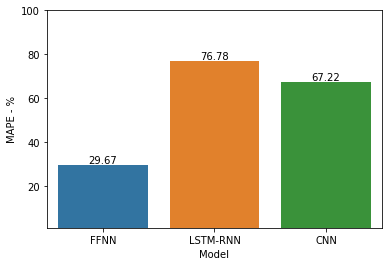

In [ ]:
models = ['FFNN', 'LSTM-RNN', 'CNN',]
MAPE = [29.67, 76.78, 67.22,]

comparison = pd.DataFrame({'Model':models, 'MAPE':MAPE})

sns.barplot(x = 'Model', y = 'MAPE', data = comparison)
plt.ylim(0, 100)
plt.xlabel("Model")
plt.ylabel("MAPE - %")

#place the labels
ax = plt.gca()
y_max = comparison['MAPE'].value_counts().max() 
ax.set_ylim(1)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
        ha='center', va='bottom')
plt.show()

(0.0, 3.5)

Text(0.5, 0, 'Model')

Text(0, 0.5, 'RMSE - kWh')

(1.0, 3.5)

Text(0.0, 2.02, '2.02')

Text(1.0, 2.88, '2.88')

Text(2.0, 2.9, '2.90')

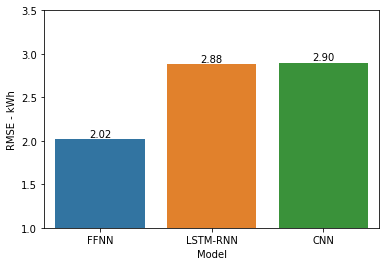

In [ ]:
models = ['FFNN', 'LSTM-RNN', 'CNN',]
rmse = [2.02, 2.88, 2.90]

comparison = pd.DataFrame({'Model':models, 'RMSE':rmse})

sns.barplot(x = 'Model', y = 'RMSE', data = comparison)
plt.ylim(0, 3.5)
plt.xlabel("Model")
plt.ylabel("RMSE - kWh")

#place the labels
ax = plt.gca()
y_max = comparison['RMSE'].value_counts().max() 
ax.set_ylim(1)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
        ha='center', va='bottom')